## Imports

In [40]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import glob

import cv2

# create a venv >> python -m venv .venv
# activate the venv >> .venv\Scripts\activate
# install opencv >> pip install opencv-python
# >> pip install ipykernel numpy matplotlib
# >> python -m ipykernel install --user --name=stereo_vision --display-name="StereoVision (venv)"

#### Helper Functions

In [41]:
# ----- Helpers --------
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return np.uint8(gray)

## Calibration

In [ ]:
# We choose c4 as it has the most planar perspective
chosen_img_left = "c4Left.png"
chosen_img_right = "c4Right.png"

# chosen_img_left = "c2Left.png"
# chosen_img_right = "c2Right.png"

# chosen_img_left = "c3Left.png"       #! Doesn't detect...
# chosen_img_right = "c3Right.png"

# chosen_img_left = "c1Left.png"
# chosen_img_right = "c1Right.png"



### Docs

In [43]:
### Documentation :


# cv2.findChessboardCorners(): This function is used to find the chessboard corners in an image.
    # https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a

# cv2.cornerSubPix(): This function will improve precision of corner's positions.    
    # https://docs.opencv.org/4.0.0/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e

# cv2.drawChessboardCorners(): This function will draw found corners for visual validation purpose. 
    # https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022

# cv2.calibrateCamera(): This function will compute rotation vectors, and , based on corners found on multiple chessboards.
    # https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d

### Implementation

In [44]:
def detect_chessboard_corners(image_path, pattern_size=(7, 7)):
    """
    Detect corners in an image and return results for display.
    """
    # Read
    img = cv2.imread(image_path)
        
    # Convert to grayscale
    grey = rgb2gray(img)
    
    # Find chessboard corners
    retval, corners = cv2.findChessboardCorners(img, pattern_size, None)
    
    # Prepare result dictionary
    result = {
        'success': retval,
        'image_rgb': cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
        'corners': None,
        'image_with_corners': cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    }
    
    if retval:
        # Improve corner precision
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        refined_corners = cv2.cornerSubPix(grey, corners, (11, 11), (-1, -1), criteria)
        
        # Draw corners on a copy of the image
        img_with_corners = img.copy()
        cv2.drawChessboardCorners(img_with_corners, pattern_size, refined_corners, retval)
        
        # Update result
        result['corners'] = refined_corners
        result['image_with_corners'] = cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB)
    
    return result

#### Example

Corners detected successfully in both images!
Left image corners shape: (49, 1, 2)
Right image corners shape: (49, 1, 2)


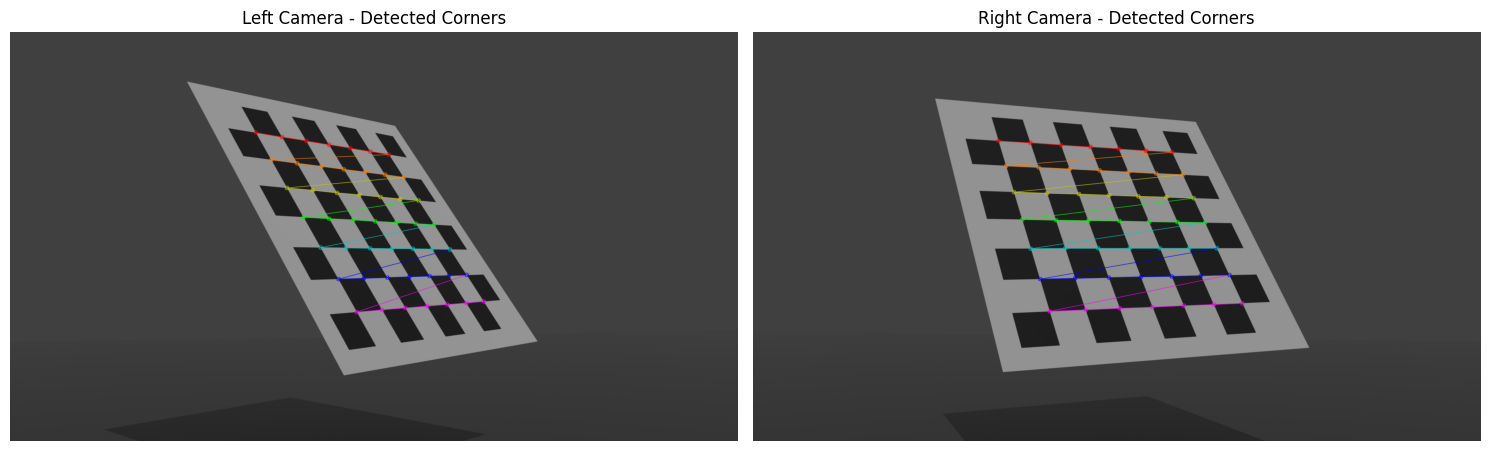

In [45]:
# EXAMPLE: set of one L/R images
result_left = detect_chessboard_corners(f"./chessboards/{chosen_img_left}")
result_right = detect_chessboard_corners(f"./chessboards/{chosen_img_right}")

# Display results
if result_left['success'] and result_right['success']:
    print("Corners detected successfully in both images!")
    print(f"Left image corners shape: {result_left['corners'].shape}")
    print(f"Right image corners shape: {result_right['corners'].shape}")
else:
    print(f"Corner detection - Left: {result_left['success']}, Right: {result_right['success']}")


# ====================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Display left image with corners
ax1.imshow(result_left['image_with_corners'])
ax1.set_title('Left Camera - Detected Corners')
ax1.axis('off')

# Display right image with corners
ax2.imshow(result_right['image_with_corners'])
ax2.set_title('Right Camera - Detected Corners')
ax2.axis('off')

plt.tight_layout()
plt.show()

### Camera Calibration

In [46]:
# INPUT:
    # objectPoints: Vector of vectors of calibration pattern points in the calibration pattern coordinate space.
    # imagePoints: 	Vector of vectors of the projections of calibration pattern points.
    # imageSize: Size of the image used only to initialize the intrinsic camera matrix.

# OUTPUT:
    # retval: RMS reprojection error
    # cameraMatrix:  Refined camera intrinsic matrix
    # distCoeffs: Output vector of distortion coefficients.
    # rvecs: Output vector of rotation vectors
    # tvecs 

# More images passed -> better results
# Pass a list of images, receive a list of Projection Matrixes P.
# Choose the final P and P' based on the image with the orientation the most similar to final 3D image (here c4.png)


def calibrate_camera(img_list, pattern_size):
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)            # Shape: (49, 3) for 7×7 corners
    objp[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)  # copy objp for each image
    object_points = []  # 3D points in real world space
    image_points = []   # 2D points in image plane
    successful_images = [] 

    for i in img_list:
        result = detect_chessboard_corners(i, pattern_size)
        if result["success"]:
            object_points.append(objp)
            image_points.append(result["corners"])
            successful_images.append(i)

    # Get image size from the first image
    first_img = cv2.imread(img_list[0])
    image_size = (first_img.shape[1], first_img.shape[0])  # (width, height)
        #print(f"Image size: {image_size}")

    # Calibrate camera
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        object_points, 
        image_points, 
        image_size, 
        None,  # Let OpenCV estimate initial camera matrix
        None   # Let OpenCV estimate initial distortion coefficients
    )

    return ret, camera_matrix, dist_coeffs, rvecs, tvecs, successful_images


In [47]:
# Load images
img_list = glob.glob("./chessboards/*.png")
print("Found images:", len(img_list))

# Get Results
result = calibrate_camera(img_list, (7,7))
ret, camera_matrix, dist_coeffs, rvecs, tvecs, successful_images = result
print(f"Successfully calibrated on {len(successful_images)} images.")

# Find indices
left_idx = next(i for i, path in enumerate(successful_images) if chosen_img_left in path)
right_idx = next(i for i, path in enumerate(successful_images) if chosen_img_right in path)

# Extract parameters for both
ret_left, mtx_left, dist_left = ret, camera_matrix, dist_coeffs
rvec_left, tvec_left = rvecs[left_idx], tvecs[left_idx]

ret_right, mtx_right, dist_right = ret, camera_matrix, dist_coeffs  
rvec_right, tvec_right = rvecs[right_idx], tvecs[right_idx]

# Display results
print(f"Left: rvec={rvec_left.flatten()}, tvec={tvec_left.flatten()}")
print(f"Right: rvec={rvec_right.flatten()}, tvec={tvec_right.flatten()}")


Found images: 8
Successfully calibrated on 6 images.
Left: rvec=[-0.63212698 -0.86623592 -0.2792394 ], tvec=[-3.25755808 -2.84175776 21.95219141]
Right: rvec=[-0.66821239 -0.47988878 -0.16349578], tvec=[-3.46269851 -2.77397345 23.25761646]
Successfully calibrated on 6 images.
Left: rvec=[-0.63212698 -0.86623592 -0.2792394 ], tvec=[-3.25755808 -2.84175776 21.95219141]
Right: rvec=[-0.66821239 -0.47988878 -0.16349578], tvec=[-3.46269851 -2.77397345 23.25761646]


### Projection Matrixes

In [48]:
# Convert rotation vectors to rotation matrices
R_left, _ = cv2.Rodrigues(rvec_left)   # 3x3 rotation matrix
R_right, _ = cv2.Rodrigues(rvec_right) # 3x3 rotation matrix

# Build extrinsic matrices [R|t] (3x4)
RT_left = np.hstack([R_left, tvec_left.reshape(-1, 1)])
RT_right = np.hstack([R_right, tvec_right.reshape(-1, 1)]) 

# Build projection matrices P = K * [R|t] (3x4)
P_left = camera_matrix @ RT_left
P_right = camera_matrix @ RT_right

print("Left Projection Matrix P:")
print(P_left)
print("\nRight Projection Matrix P':")
print(P_right)
print(f"\nCheck dimensions ok (3x4): P_left={P_left.shape}, P_right={P_right.shape}")


# ================ CHECK ========================

# 1. Check if decomposition gives back original matrices
print("=== 1. MATRIX DECOMPOSITION CHECK ===")
K_left_check, R_left_check, t_left_check, _, _, _, _ = cv2.decomposeProjectionMatrix(P_left)
K_right_check, R_right_check, t_right_check, _, _, _, _ = cv2.decomposeProjectionMatrix(P_right)

# Normalize K matrices (they come back scaled)
K_left_check = K_left_check / K_left_check[2, 2]
K_right_check = K_right_check / K_right_check[2, 2]
camera_matrix_norm = camera_matrix / camera_matrix[2, 2]
# print(f"Original K:\n{camera_matrix_norm}")
# print(f"Decomposed K (left):\n{K_left_check}")
print(f"K matrices match: {np.allclose(camera_matrix_norm, K_left_check, atol=1e-3)}")

# 2. Check rotation matrix properties
print("\n=== 2. ROTATION MATRIX VALIDATION ===")
det_R_left = np.linalg.det(R_left)
det_R_right = np.linalg.det(R_right)
print(f"det(R_left) = {det_R_left:.6f} (should be ≈ 1.0)")
print(f"det(R_right) = {det_R_right:.6f} (should be ≈ 1.0)")

# Check orthogonality: R @ R.T should be identity
ortho_left = np.allclose(R_left @ R_left.T, np.eye(3), atol=1e-6)
ortho_right = np.allclose(R_right @ R_right.T, np.eye(3), atol=1e-6)
print(f"R_left is orthogonal: {ortho_left}")
print(f"R_right is orthogonal: {ortho_right}")

# 3. Check camera centers and baseline
print("\n=== 3. CAMERA GEOMETRY ===")
C_left = -R_left.T @ tvec_left.reshape(-1, 1)
C_right = -R_right.T @ tvec_right.reshape(-1, 1)
baseline = np.linalg.norm(C_left - C_right)

print(f"Left camera center: {C_left.flatten()}")
print(f"Right camera center: {C_right.flatten()}")
print(f"Baseline distance: {baseline:.4f}")
print(f"Baseline OK (>0.01): {baseline > 0.01}")

# 4. CRITICAL: Reprojection error test
print("\n=== 4. REPROJECTION ERROR TEST ===")

# Create 3D chessboard points
objp = np.zeros((7 * 7, 3), np.float32)
objp[:,:2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2)
objp_homogeneous = np.hstack([objp, np.ones((objp.shape[0], 1))]).T  # 4x49

# Project using P matrices
projected_left = P_left @ objp_homogeneous
projected_left = (projected_left[:2, :] / projected_left[2, :]).T  # Convert to 2D

projected_right = P_right @ objp_homogeneous
projected_right = (projected_right[:2, :] / projected_right[2, :]).T

# Get detected corners for comparison
if 'result_left' in locals() and result_left['success']:
    detected_left = result_left['corners'].reshape(-1, 2)
    detected_right = result_right['corners'].reshape(-1, 2)
    
    # Calculate reprojection errors
    error_left = np.linalg.norm(projected_left - detected_left, axis=1)
    error_right = np.linalg.norm(projected_right - detected_right, axis=1)
    
    print(f"Left camera  - Mean error: {np.mean(error_left):.3f} px, Max: {np.max(error_left):.3f} px")
    print(f"Right camera - Mean error: {np.mean(error_right):.3f} px, Max: {np.max(error_right):.3f} px")
    
    # Overall validation result
    validation_ok = (np.mean(error_left) < 3.0 and np.mean(error_right) < 3.0 and 
                    baseline > 0.01 and ortho_left and ortho_right)
    
    print(f"\n=== OVERALL VALIDATION: {'✓ PASS' if validation_ok else '✗ FAIL'} ===")
    
    if not validation_ok:
        print("Issues detected:")
        if np.mean(error_left) >= 3.0 or np.mean(error_right) >= 3.0:
            print("- High reprojection error: P matrices incorrect")
        if baseline <= 0.01:
            print("- Baseline too small: cameras too close or calibration failed")
        if not ortho_left or not ortho_right:
            print("- Invalid rotation matrices")
else:
    print("ERROR: No corner detection results available for comparison")





Left Projection Matrix P:
[[ 2.06328930e+03  6.06557728e+02 -8.39479573e+02  1.42311308e+04]
 [ 4.65027710e+02  1.43109546e+03  1.56044541e+03  5.87027599e+03]
 [ 7.79116606e-01 -4.01410642e-01  4.81504736e-01  2.19521914e+01]]

Right Projection Matrix P':
[[ 2.30317261e+03  8.85049873e+01 -1.31771720e+02  1.50534231e+04]
 [ 2.70180299e+02  1.33170144e+03  1.68903782e+03  6.71650487e+03]
 [ 4.77062389e-01 -5.55588147e-01  6.80979654e-01  2.32576165e+01]]

Check dimensions ok (3x4): P_left=(3, 4), P_right=(3, 4)
=== 1. MATRIX DECOMPOSITION CHECK ===
K matrices match: True

=== 2. ROTATION MATRIX VALIDATION ===
det(R_left) = 1.000000 (should be ≈ 1.0)
det(R_right) = 1.000000 (should be ≈ 1.0)
R_left is orthogonal: True
R_right is orthogonal: True

=== 3. CAMERA GEOMETRY ===
Left camera center: [-15.00162035  12.58054396 -10.82900181]
Right camera center: [ -8.0350522   16.10228687 -15.3868849 ]
Baseline distance: 9.0394
Baseline OK (>0.01): True

=== 4. REPROJECTION ERROR TEST ===
Left c

### Fundamental Matrix

In [49]:
# Suppose prime is right, non-prime is left.

# Extract corresponding points from c4 images for OpenCV method
result_left= detect_chessboard_corners(f"./chessboards/{chosen_img_left}")
result_right = detect_chessboard_corners(f"./chessboards/{chosen_img_right}")

if result_left['success'] and result_right['success']:
    # Get corresponding corner points
    pts_left = result_left['corners'].reshape(-1, 2)
    pts_right = result_right['corners'].reshape(-1, 2)

    # Compute fundamental matrix using OpenCV
    F_opencv, mask = cv2.findFundamentalMat(pts_left, pts_right, cv2.FM_8POINT)       #https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga59b0d57f46f8677fb5904294a23d404a
    
    print("Fundamental Matrix F (OpenCV):")
    print(F_opencv)

    # Check Epipolar constraint for all inlier points
    print(f"Inliers (epipolar constraint checks): {np.sum(mask)} / {len(mask)} passed.")




# ================================================== Theoretical computation of F
# Equation :  F =  e' * P' * P+  = P'× C * ...
            # F = P_right @ C_left * P_left_pinv

# Camera's optical centers (T = -RC  <=> C = -R^T * T)
# C_left = -R_left.T @ tvec_left.reshape(-1, 1)     # reshape: turns [x, y, z] into [[x], [y], [z]]
# C_right = -R_right.T @ tvec_right.reshape(-1, 1)

# # P+: Pseudo-inverse of P  : https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html
# P_left_pinv = np.linalg.pinv(P_left)


# # e' : epipole
# C_left_homogeneous = np.vstack((C_left, 1))  # Convert C_left to homogeneous coordinates
# e_prime = P_right @ C_left_homogeneous


Fundamental Matrix F (OpenCV):
[[ 4.89794219e-06 -1.66930171e-05 -1.52784398e-02]
 [ 2.04063003e-05 -7.25651889e-06 -6.97811451e-03]
 [ 1.25178707e-02  1.35238648e-03  1.00000000e+00]]
Inliers (epipolar constraint checks): 49 / 49 passed.


## 3D

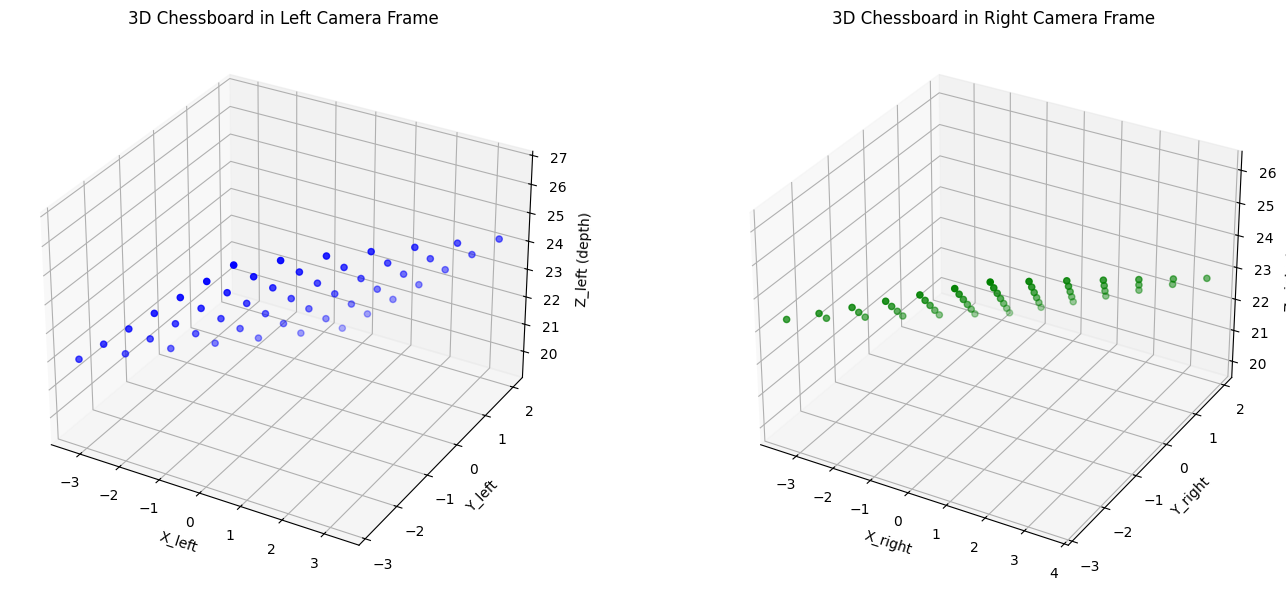

In [50]:
# Use your helper to get corners (handles loading and errors)
result_left = detect_chessboard_corners(f"./chessboards/{chosen_img_left}")
result_right = detect_chessboard_corners(f"./chessboards/{chosen_img_right}")

if result_left['success'] and result_right['success']:
    corners_left = result_left['corners']
    corners_right = result_right['corners']

    # Triangulate (OpenCV expects 2xN arrays)
    X_hom = cv2.triangulatePoints(P_left, P_right, corners_left.reshape(-1,2).T, corners_right.reshape(-1,2).T)
    X = (X_hom[:3] / X_hom[3]).T  # Nx3

    # Express to Camera Frame (triangulatePoints is in board 2D frame)
    X_left_cam = (R_left @ X.T + tvec_left.reshape(3, 1)).T
    X_right_cam = (R_right @ X.T + tvec_right.reshape(3, 1)).T

    # ============================================================

    # 3D scatter: left and right camera frames side by side
    # World->camera: x_cam = R * X_world + t
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(15, 6))
    ax1.scatter(X_left_cam[:, 0], X_left_cam[:, 1], X_left_cam[:, 2], c='b', marker='o')
    ax1.set_title('3D Chessboard in Left Camera Frame')
    ax1.set_xlabel('X_left')
    ax1.set_ylabel('Y_left')
    ax1.set_zlabel('Z_left (depth)')

    ax2.scatter(X_right_cam[:, 0], X_right_cam[:, 1], X_right_cam[:, 2], c='g', marker='o')
    ax2.set_title('3D Chessboard in Right Camera Frame')
    ax2.set_xlabel('X_right')
    ax2.set_ylabel('Y_right')
    ax2.set_zlabel('Z_right (depth)')

    plt.tight_layout()
    plt.show()

    

## Next
